# **ESERCIZIO 10**

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lowest temperature.

## Soluzione:

Ho scelto di risolvere il primo dei due punti.

Parallelizzare un codice significa suddividere il compito principale in sotto-problemi che possono essere risolti simultaneamente, sfruttando processori diversi allo stesso tempo. Questa tecnica consente di utilizzare meglio le risorse computazionali (ad esempio possiamo usare diversi processori economici invece di una singola CPU all'avanguardia e costosa) e di ridurre considerevolmente il tempo di esecuzione.

Il calcolo parallelo può essere realizzato in diversi modi, a seconda del numero di flussi di istruzioni e di accessi in memoria, che possono essere singoli o multipli. In questo esercizio è stato adottato l’approccio SPMD (Single Program Multiple Data), in cui lo stesso eseguibile viene lanciato su più processori, ciascuno dei quali lavora su un insieme di dati diverso, e tutti i processi comunicano tra loro attraverso un buffer condiviso. Per implementare questo tipo di approccio ho utilizzato la libreria MPI (Message Passing Interface), che mette a disposizione diverse funzioni utili elencate e spiegate qui sotto:

- `MPI_Init(int *argc, char **argv)`: inizializza i processi paralleli, quindi deve essere chiamata prima di ogni altra istruzione MPI. Riceve come input gli argomenti da riga di comando, imposta il numero di processi desiderati e li collega tramite il comunicatore `MPI_COMM_WORLD`.

- `MPI_Finalize()`: termina tutti i processi paralleli. Non è sicuro eseguire alcuna istruzione MPI prima di `MPI_Init()` o dopo `MPI_Finalize()`.

- `MPI_Comm_size(MPI_Comm comm, int *size)`: inizializza la variabile `size`, che rappresenta il numero totale di processi paralleli. Una volta chiamata, ogni processo diventa "consapevole" del numero totale di processi nel comunicatore.

- `MPI_Comm_rank(MPI_Comm comm, int *rank)`: assegna a ogni processo un `rank`, ovvero un identificativo univoco all’interno del comunicatore. Quando viene chiamata, ogni processo ottiene un nome distinto.

- `MPI_Send(void *buffer, int n, MPI_Datatype datatype, int target, int tag, MPI_Comm comm)`: invia `n` elementi di tipo `datatype` dal processo corrente al processo `target` nel comunicatore `comm`, usando `tag` come etichetta per il messaggio. I dati da inviare devono essere passati come puntatore.

- `MPI_Recv(void *buffer, int n, MPI_Datatype datatype, int target, int tag, MPI_Comm comm, MPI_Status *status)`: riceve `n` elementi di tipo `datatype` dal processo `target` nel comunicatore `comm`, usando `tag` come etichetta e `status` per ricevere informazioni sul messaggio. Anche qui i dati sono passati come puntatore.

- `MPI_Bcast(void *buffer, int n, MPI_Datatype datatype, int root, MPI_Comm comm)`: trasmette `n` elementi di tipo `datatype` dal processo `root` a tutti gli altri processi nel comunicatore `comm`. I dati trasmessi sono passati come puntatore.

- `MPI_Gather(void *sendbuf, int n_send, MPI_Datatype sendtype, void *recvbuf, int n_recv, MPI_Datatype recvtype, int root, MPI_Comm comm)`: raccoglie 

- `n_send` elementi di tipo `sendtype` da tutti i processi e li invia al processo `root`, che riceve `n_recv` elementi di tipo `recvtype`. Tutti i dati vanno passati come puntatori.

- `MPI_Reduce(void *sendbuf, void *recvbuf, int n, MPI_Datatype datatype, MPI_Op op, int root, MPI_Comm comm)`: riduce `n` elementi di tipo `datatype` da tutti i processi in un unico risultato nel processo `root`, applicando un'operazione `op` come somma, minimo, massimo, ecc.

- `MPI_Barrier()`: forza tutti i processi ad attendere che tutti gli altri abbiano raggiunto lo stesso punto. È utile ad esempio prima di chiamare `MPI_Gather()` per evitare la raccolta di dati ancora non elaborati.

## Scambio di Informazioni tra Processi Paralleli:
La libreria MPI è in grado di gestire lo scambio di informazioni tra processi solo per dati di tipo Semplice: non è possibile invece scambiare elemnti appartenenti a classi o tipi di dati più "evoluti".
Gestire questo tipo di scambi è stata la sfida più complessa nell'implementare questo codice.


Nel mio programma, le informazioni vengono scambiate tra i processi ogni 50 generazioni.

Per risolvere il problema dello scambio di dati "semplici" ho agito in questo modo:
- dopo aver ordinato la popolazione per loss crescente (individui migliori nelle prime posizioni del vettore _path contenuto nella classe Population), ho implementato un metodo che mi restituisse il percorso proposto dal migliore individuo della generazione corrente:
```c++
vector<int> Population::get_path_pop(int d){
    return _pop[d].get_path_id();
}

vector<int> Cromosoma::get_path_id(){
    vector <int> v(_n_cities);
    for(int i=0; i<_n_cities;i++) v[i]= _path[i].id; 
    return v;
}
```


- Il percorso viene in questo modo salvato in un vettore di interi che ci dice l'ordine in cui visitare le città. E' questo il vettore di dati "semplici" che viene scambiato tra i vari processi.

- I migliori path provenienti da ciascun core vengono immagazzinati nel vettore `vector<int> tutti_ordini(Nc * size);` che ha dimensione : numero_di_città*numero_di_processi .

- Successivamente ogni processo,  prende il miglior percorso proveniente da ciascuno degli altri processi (diversi da sè) e lo usa per sostituire il proprio individuo peggiore ( tramite la il metodo `pop.Reorder( npop-1, best );` ), migliorando così la qualità della popolazione grazie alla condivisione delle migliori soluzioni.

```c++
void Population:: Reorder( int n, vector<int> v){
    _pop[n].Reorder( v);
}

void Cromosoma:: Reorder( vector<int> v){
    vector <City> newpath;

    if(v.size() != static_cast<std::vector<int>::size_type>(_n_cities) ) {cout << "ERRORE: impossibile riordinare il vettore per differenza di size." << endl ;exit(-2);}
    for (int id : v) {
        auto it = find_if(_path.begin(), _path.end(), [id](const City& c) { //metto lambda funct al 3 posto della funzione che richiederebbe un booleano
            return c.id == id; // se trova la città restituisce true, e quindi la fz find if individua quell'elemento lì.
        });

        if(it != _path.end()){ 
            newpath.push_back(*it); // faccio il pushback dell elemento città indicato dall'iteratore.
        }else{ cout<< "Problema nel riordinamento del vettore tramite gli id nella fz Reorder." << endl ; exit(-2);}
    }
    Cromosoma newcromo(newpath, _n_cities); 
    newcromo.Loss();
    this->Loss();
    if( newcromo.get_Loss() >= this->get_Loss()) {cout << endl << "Lo scambio di cromosomi tra i core è sconveniente"<< endl ;
    }else{ 
        _path = move(newpath);
        this->Loss(); // dopo aver cambiato il path ricalcolo la loss del mio cromosoma in questione
         }
}
```


- Infine la popolazione viene Riordinata tramite il metodo `pop.SortByLoss();` in modo da ripristinare l'ordine crescente degli individui in funzione della Loss dopo il miglioramento della popolazione.


```c++
if(i%50 ==0){ // ogni 50 iterazioni scambia
            pop.SortByLoss(); // ordino la popolazione

            vector <int> ordine = pop.get_path_pop(0); //prendo vettore di interi con gli id del cromosoma migliore
            int Nc = ordine.size(); //numero citta nel path

            vector<int> tutti_ordini(Nc * size); //creo un vettore che abbia come dimensionni: il numero di città* il numero di processi paralleli su cui sto avanzando

            MPI_Allgather(ordine.data(), Nc , MPI_INT,// MPI_INT mi dice il tipo dei dati che sto scambiando
              tutti_ordini.data(), Nc  , MPI_INT, // metto ancora Nc perche voglio il numero di dati raccolti perogni processo
              MPI_COMM_WORLD);
              
            for(int k=0; k<size; k++){
                vector <int> best(Nc); //questo vettore contiene Nc(numero di città) numeri identificativi 

                if(rank != k){
                    int start= k*Nc;
                    int end = (k+1) * Nc;
                    best.assign(tutti_ordini.begin() + start, tutti_ordini.begin() + end); // iteratore finale escluso dall'assegnazione.
                    pop.Reorder( npop-1, best ); // riordino l'ultimo vettore nella popolazione, ovvero il peggiore, come il migliore della popolazione vicina
                    pop.SortByLoss();
                     
                }
                
            }
        }
```



- Nei seguenti plot mostro come ci sia un guadagno evidente nell' utilizzare vari core comunicanti in modo parallelo:

Nel caso di entrambi i percorsi (sia nella traiettoria circolare che in quella dentro al quadrato) ho una popolazione di **140** membri che viene fatta evolvere per 200 generazioni trovando la configurazione ideale: ovvero la stessa che nell'esercizio 9 veniva trovata rispettivamente dopo 600 generazioni per il path circolare e 1000 generazioni per quello nel quadrato

/tmp/ipykernel_10366/2549608129.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  initial_sq = pd.read_csv("Esercizio10.1/OUTPUT/quadrato/cities1.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/2549608129.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  final_sq = pd.read_csv("Esercizio10.1/OUTPUT/quadrato/best_path_rank0.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/2549608129.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  initial_circ = pd.read_csv("Esercizio10.1/OUTPUT/circonferenza/cities1.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/2549608129.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``se

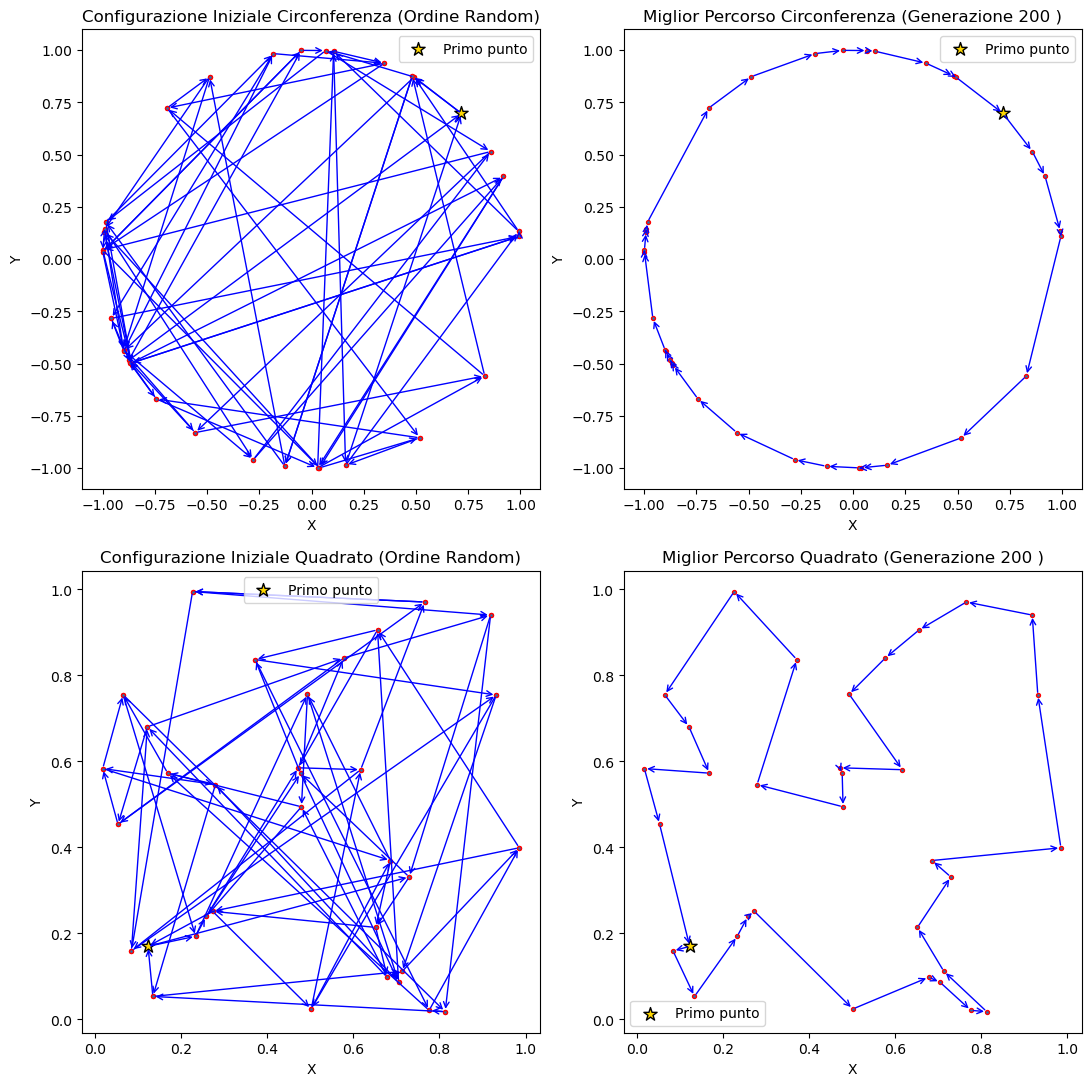

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

initial_sq = pd.read_csv("Esercizio10.1/OUTPUT/quadrato/cities1.out" ,delim_whitespace=True)
final_sq = pd.read_csv("Esercizio10.1/OUTPUT/quadrato/best_path_rank0.out" ,delim_whitespace=True)
initial_circ = pd.read_csv("Esercizio10.1/OUTPUT/circonferenza/cities1.out" ,delim_whitespace=True)
final_circ = pd.read_csv("Esercizio10.1/OUTPUT/circonferenza/best_path_rank2.out" ,delim_whitespace=True)


def draw_arrows(ax, x, y, color='blue'):
    for i in range(len(x) - 1):
        ax.annotate("",
                    xy=(x[i+1], y[i+1]),
                    xytext=(x[i], y[i]),
                    arrowprops=dict(arrowstyle="->", color=color, lw=1),
                    size=10)
    # Chiudo collegando l'ultimo pto del path al primo con una freccetta
    ax.annotate("",
                xy=(x[0], y[0]),
                xytext=(x[-1], y[-1]),
                arrowprops=dict(arrowstyle="->", color=color, lw=1))

# Plot
fig, axes = plt.subplots(2, 2, figsize=(11, 11))

datasets = [
    (initial_circ, "Configurazione Iniziale Circonferenza (Ordine Random)"),
    (final_circ, "Miglior Percorso Circonferenza (Generazione 200 )"),
    (initial_sq, "Configurazione Iniziale Quadrato (Ordine Random)"),
    (final_sq, "Miglior Percorso Quadrato (Generazione 200 )")
]

for ax, (df, title) in zip(axes.flat, datasets):
    x = df['X'].values
    y = df['Y'].values
    ax.scatter(x, y, s=8, edgecolor='r')
    draw_arrows(ax, x, y, color='blue')

    # Evidenzia il primo punto (city_id == 1)
    idx = df.index[df['city_id'] == 1][0]
    ax.scatter(df.loc[idx, 'X'], df.loc[idx, 'Y'],
               color='gold', edgecolor='black', s=100, marker='*', label='Primo punto')

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

/tmp/ipykernel_10366/3937285697.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  path0 = pd.read_csv("Esercizio10.2/OUTPUT/core0/path_0.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/3937285697.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  path3000 = pd.read_csv( "Esercizio10.2/OUTPUT/core0/path_3000.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/3937285697.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  path7000 = pd.read_csv( "Esercizio10.2/OUTPUT/core0/path_7000.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/3937285697.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss_r

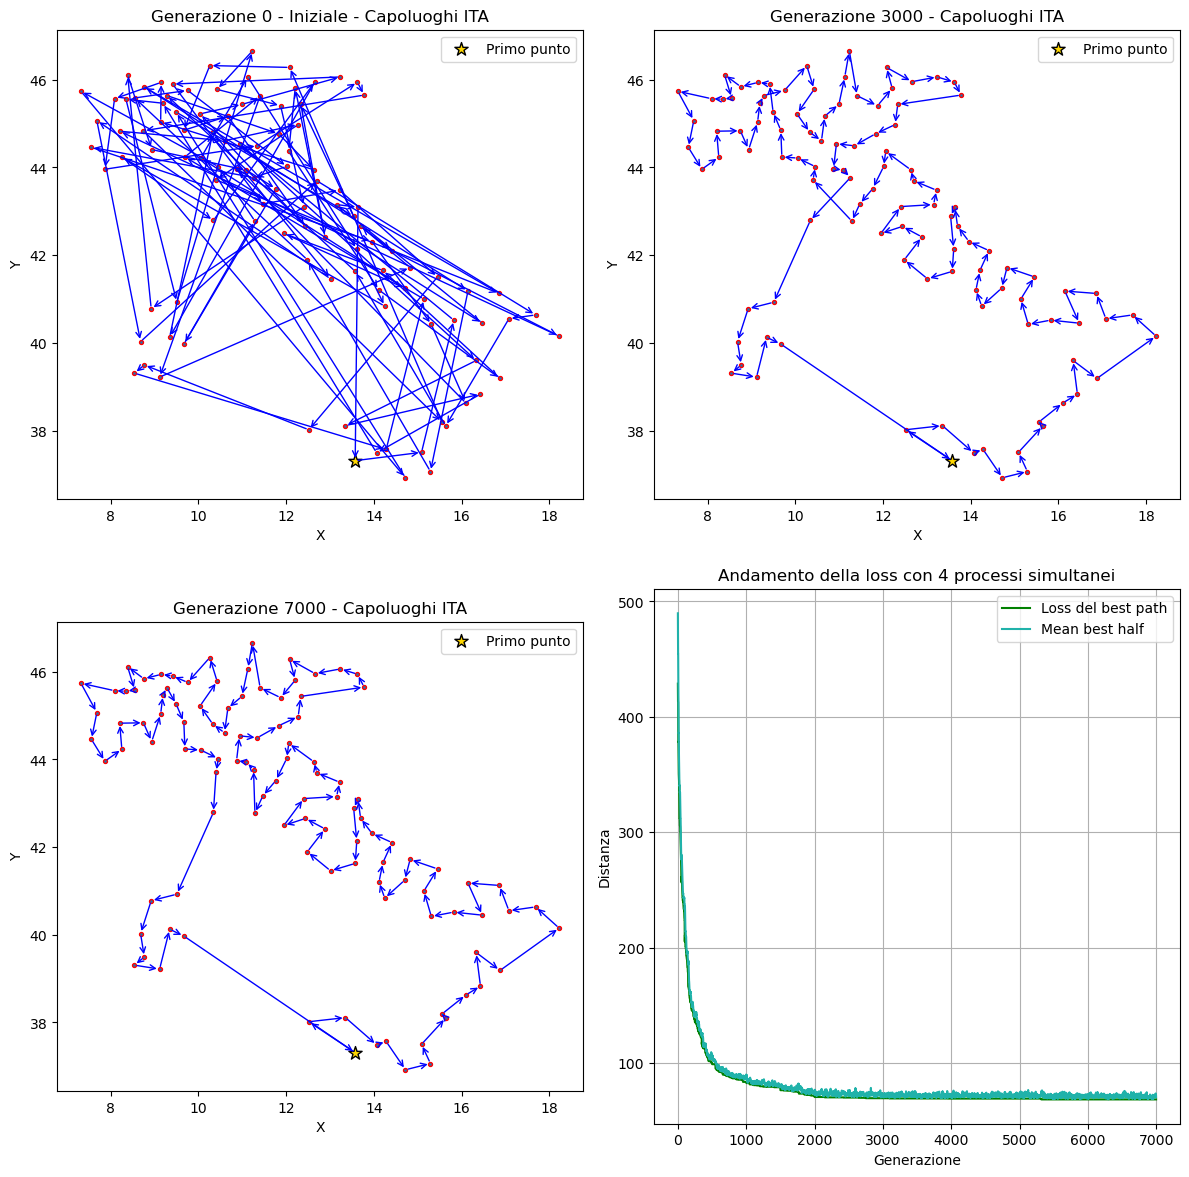

In [35]:
path0 = pd.read_csv("Esercizio10.2/OUTPUT/core0/path_0.out" ,delim_whitespace=True)
path3000 = pd.read_csv( "Esercizio10.2/OUTPUT/core0/path_3000.out" ,delim_whitespace=True)
path7000 = pd.read_csv( "Esercizio10.2/OUTPUT/core0/path_7000.out" ,delim_whitespace=True)
loss_rec = pd.read_csv( "Esercizio10.2/OUTPUT/core0/loss_record.out" ,delim_whitespace=True)

datasets1 = [
    (path0, "Generazione 0 - Iniziale - Capoluoghi ITA"),
    (path3000, "Generazione 3000 - Capoluoghi ITA"),
    (path7000, "Generazione 7000 - Capoluoghi ITA"),
]

# Setup dei subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for ax, (df, title) in zip(axes.flat, datasets1):
    x = df['X'].values
    y = df['Y'].values
    ax.scatter(x, y, s=8, edgecolor='r')
    draw_arrows(ax, x, y, color='blue')

    # Evidenzia il primo punto (city_id == 1)
    idx = df.index[df['city_id'] == 1][0]
    ax.scatter(df.loc[idx, 'X'], df.loc[idx, 'Y'],
               color='gold', edgecolor='black', s=100, marker='*', label='Primo punto')

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.set_aspect('equal')

ax_loss = axes[1, 1]
ax_loss.plot(loss_rec['N'], loss_rec['L'], label='Loss del best path', color='green')
ax_loss.plot(loss_rec['N'], loss_rec['Half_pop_ave'], label='Mean best half', color='lightseagreen')
ax_loss.set_title('Andamento della loss con 4 processi simultanei')
ax_loss.set_xlabel('Generazione')
ax_loss.set_ylabel('Distanza')
ax_loss.grid()
ax_loss.legend()



plt.tight_layout()
plt.show()

Successivamente ho eseguito il codice mantenendo i 4 processi distinti, senza che potessero scambiare tra loro informazioni.

- Nella cella sottostante mostro i grafici dell'evoluzione della popolazione per il processo numero 2, che è quello che raggiunge il risultato migliore tra i processi indipendenti.

/tmp/ipykernel_10366/3474180131.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sp_path0 = pd.read_csv("Esercizio10.2/OUTPUT/single_process/core2/path_0.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/3474180131.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sp_path3000 = pd.read_csv( "Esercizio10.2/OUTPUT/single_process/core2/path_3000.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/3474180131.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sp_path7000 = pd.read_csv( "Esercizio10.2/OUTPUT/single_process/core2/path_7000.out" ,delim_whitespace=True)
/tmp/ipykernel_10366/3474180131.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed i

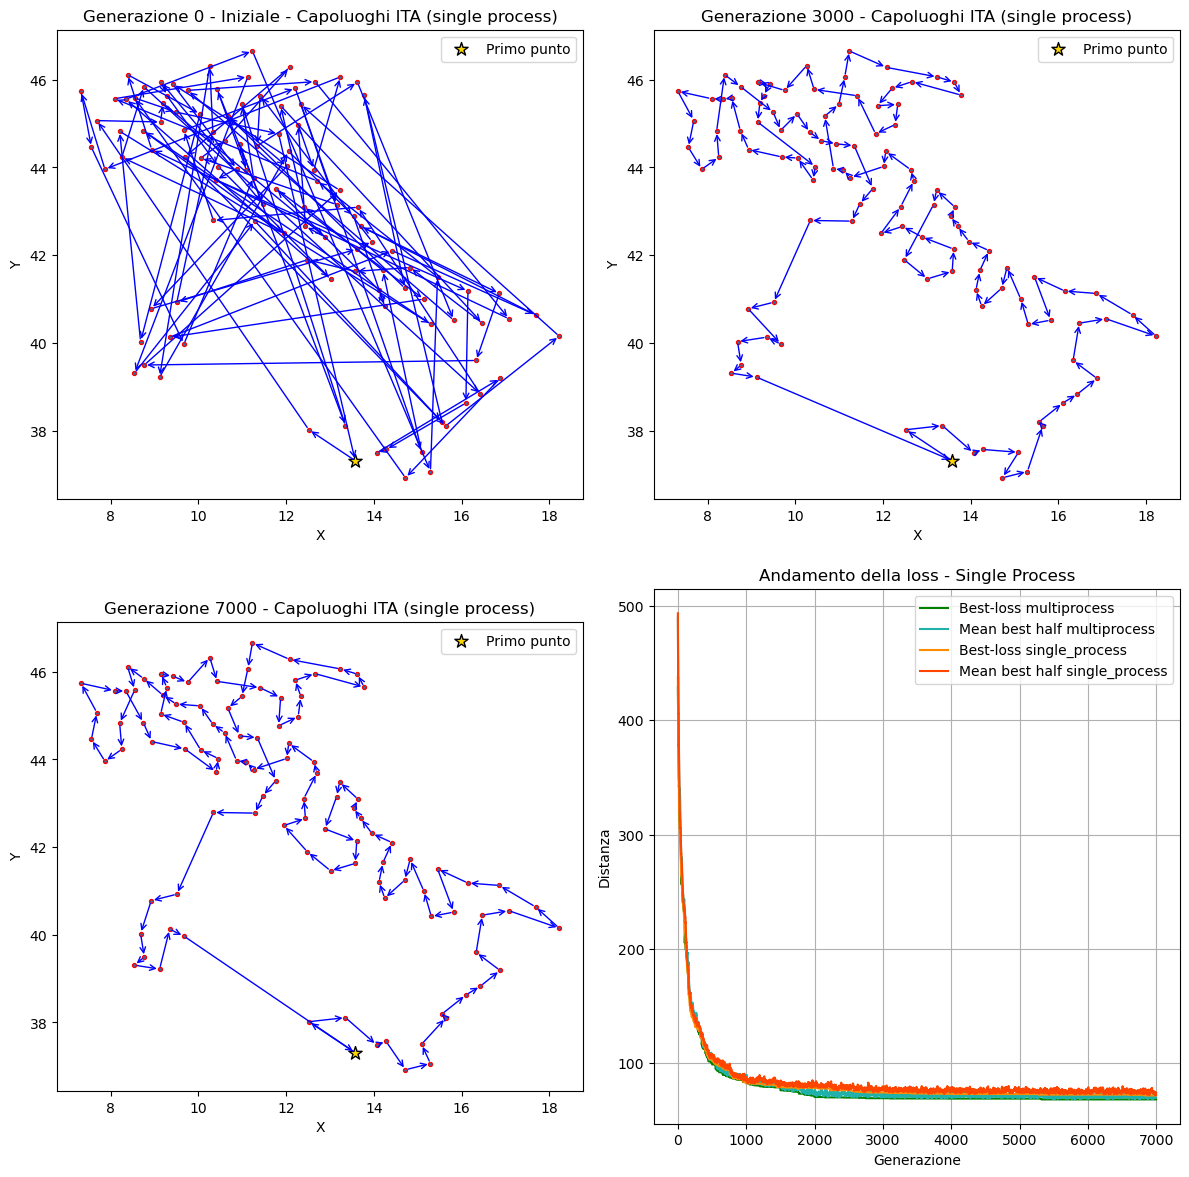

In [39]:

sp_path0 = pd.read_csv("Esercizio10.2/OUTPUT/single_process/core2/path_0.out" ,delim_whitespace=True)
sp_path3000 = pd.read_csv( "Esercizio10.2/OUTPUT/single_process/core2/path_3000.out" ,delim_whitespace=True)
sp_path7000 = pd.read_csv( "Esercizio10.2/OUTPUT/single_process/core2/path_7000.out" ,delim_whitespace=True)
sp_loss_rec = pd.read_csv( "Esercizio10.2/OUTPUT/single_process/core2/loss_record.out" ,delim_whitespace=True)
datasets2 = [ 
    (sp_path0, "Generazione 0 - Iniziale - Capoluoghi ITA (single process)"),
    (sp_path3000, "Generazione 3000 - Capoluoghi ITA (single process)"),
    (sp_path7000, "Generazione 7000 - Capoluoghi ITA (single process)"),
]

# Setup dei subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot dei percorsi
for ax, (df, title) in zip(axes.flat[:3], datasets2): 
    x = df['X'].values
    y = df['Y'].values
    ax.scatter(x, y, s=8, edgecolor='r')
    draw_arrows(ax, x, y, color='blue')

    # Evidenzia il primo punto (city_id == 1)
    idx = df.index[df['city_id'] == 1][0]
    ax.scatter(df.loc[idx, 'X'], df.loc[idx, 'Y'],
               color='gold', edgecolor='black', s=100, marker='*', label='Primo punto')

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.legend()
    ax.set_aspect('equal')

# Plot della loss nell'ultimo subplot [1, 1]
ax_loss = axes[1, 1]
ax_loss.plot(loss_rec['N'], loss_rec['L'], label='Best-loss multiprocess', color='green')
ax_loss.plot(loss_rec['N'], loss_rec['Half_pop_ave'], label='Mean best half multiprocess', color='lightseagreen')
ax_loss.plot(sp_loss_rec['N'], sp_loss_rec['L'], label='Best-loss single_process', color='darkorange')
ax_loss.plot(sp_loss_rec['N'], sp_loss_rec['Half_pop_ave'], label='Mean best half single_process', color='orangered')
ax_loss.set_title('Andamento della loss - Single Process')
ax_loss.set_xlabel('Generazione')
ax_loss.set_ylabel('Distanza')
ax_loss.grid()
ax_loss.legend()

plt.tight_layout()
plt.show()

## ZOOM DELLA DIFFERENZA TRA LE LOSS
 
- Mostro l'andamento della Loss per i migliori individui sia per l'algoritmo con 4 processi paralleli che per l'algoritmo single_process

- Lo stesso paragone è fatto anche per la loss media ottenuta sulla "best-half" degli individui della popolazione

L'andamento delle curve è plottato in funzione del numero delle generazioni.

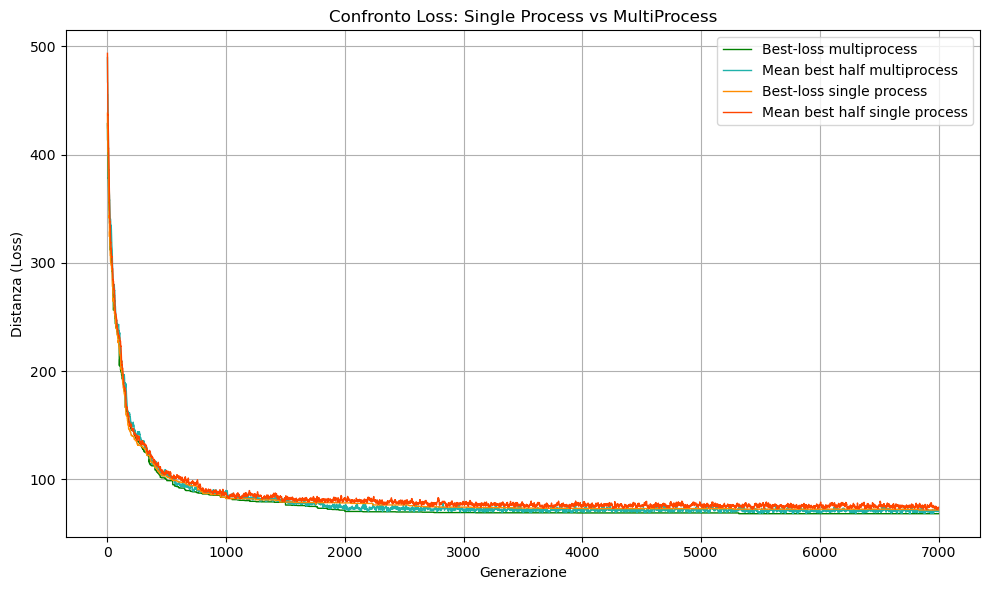

In [40]:
plt.figure(figsize=(10, 6))

# Multiprocess
plt.plot(loss_rec['N'], loss_rec['L'], label='Best-loss multiprocess', color='green', linewidth=1)
plt.plot(loss_rec['N'], loss_rec['Half_pop_ave'], label='Mean best half multiprocess', color='lightseagreen', linewidth=1)

# Single process
plt.plot(sp_loss_rec['N'], sp_loss_rec['L'], label='Best-loss single process', color='darkorange', linewidth=1)
plt.plot(sp_loss_rec['N'], sp_loss_rec['Half_pop_ave'], label='Mean best half single process', color='orangered', linewidth=1)

# Decorazioni
plt.title('Confronto Loss: Single Process vs MultiProcess')
plt.xlabel('Generazione')
plt.ylabel('Distanza (Loss)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

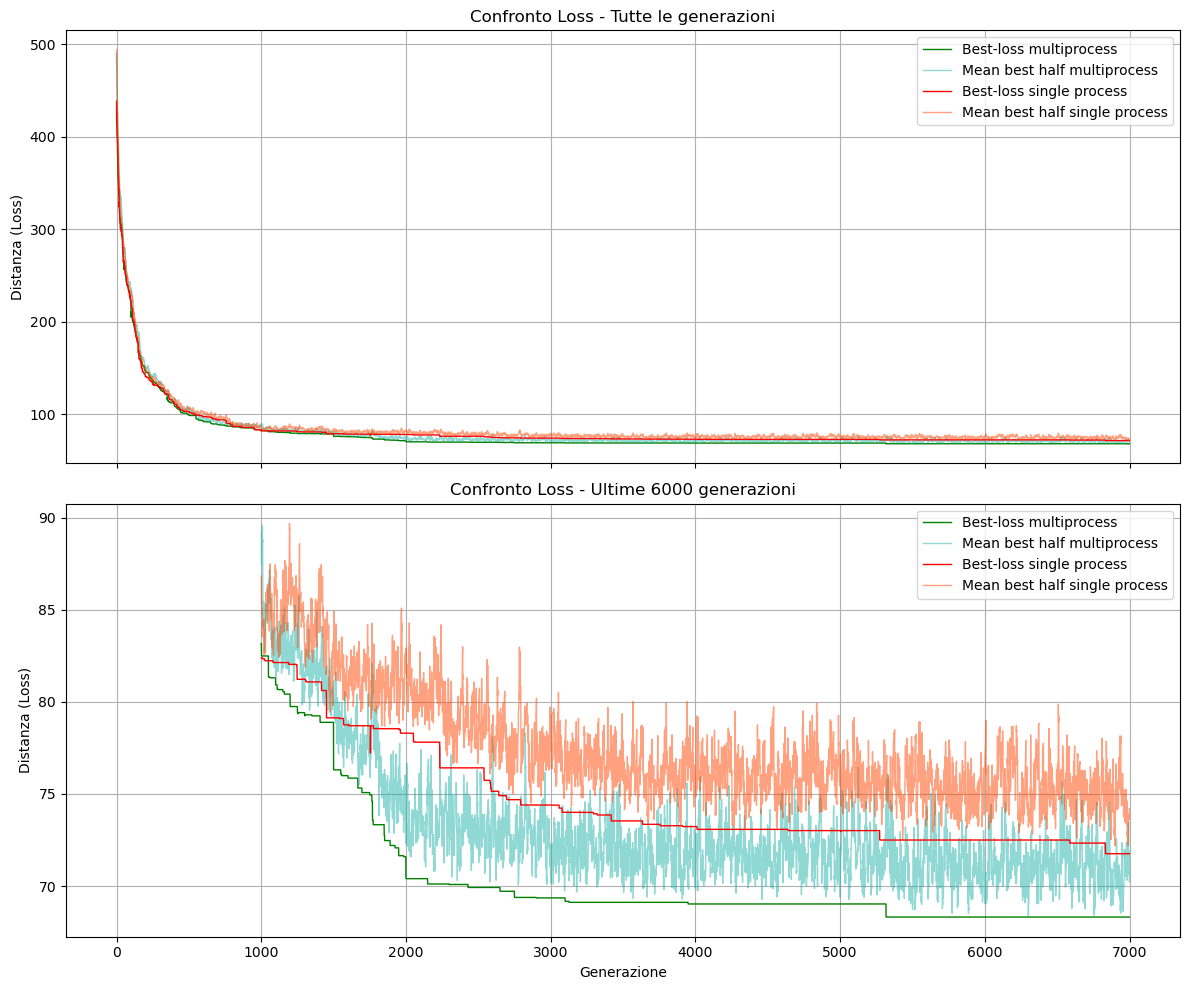

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Primo subplot: tutto l'intervallo ---
axes[0].plot(loss_rec['N'], loss_rec['L'], label='Best-loss multiprocess', color='green', linewidth=1)
axes[0].plot(loss_rec['N'], loss_rec['Half_pop_ave'], label='Mean best half multiprocess', color='lightseagreen', linewidth=1, alpha=0.5)
axes[0].plot(sp_loss_rec['N'], sp_loss_rec['L'], label='Best-loss single process', color='red', linewidth=1)
axes[0].plot(sp_loss_rec['N'], sp_loss_rec['Half_pop_ave'], label='Mean best half single process', color='orangered', linewidth=1, alpha=0.5)
axes[0].set_title('Confronto Loss - Tutte le generazioni')
axes[0].set_ylabel('Distanza (Loss)')
axes[0].legend()
axes[0].grid(True)

# --- Secondo subplot: ultimi 6000 ---
loss_rec_last = loss_rec.tail(6000)
sp_loss_rec_last = sp_loss_rec.tail(6000)

axes[1].plot(loss_rec_last['N'], loss_rec_last['L'], label='Best-loss multiprocess', color='green', linewidth=1)
axes[1].plot(loss_rec_last['N'], loss_rec_last['Half_pop_ave'], label='Mean best half multiprocess', color='lightseagreen', linewidth=1, alpha=0.5)
axes[1].plot(sp_loss_rec_last['N'], sp_loss_rec_last['L'], label='Best-loss single process', color='red', linewidth=1)
axes[1].plot(sp_loss_rec_last['N'], sp_loss_rec_last['Half_pop_ave'], label='Mean best half single process', color='orangered', linewidth=1, alpha=0.5)
axes[1].set_title('Confronto Loss - Ultime 6000 generazioni')
axes[1].set_xlabel('Generazione')
axes[1].set_ylabel('Distanza (Loss)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Posso notare che il risultato ottenuro mantenedo i 4 processi indipendenti (senza scambio di informazioni), viene raggiunto con $\sim 5000$ generazioni di anticipo dall'algoritmo multiprocess. Inoltre a parità di generazioni l'algoritmo multiprocess trova un risultato migliore.